# Mid-term Project : MLZoom-camp

## Loan Approval Classification

**Concept Study :** <br>
        My goal of this project is to use some parameters of customers to determine if they are elibible for the loan approval or not, using machine learning model, and deploy this model as a docker image to test its prediction. 

#### Feature Description

* **person_age**: Age of the person
* **person_gender**: Gender of the person
* **person_education** : Highest education level
* **person_income** : Annual income
* **person_emp_exp** : Years of employment experience
* **person_home_ownership** : Home ownership status (e.g., rent, own, mortgage)
* **loan_amnt** : Loan amount requested
* **loan_intent** : Purpose of the loan
* **loan_int_rate** : Loan interest rate
* **loan_percent_income** : Loan amount as a percentage of annual income
* **cb_person_cred_hist_length** : Length of credit history in years
* **credit_score** : Credit score of the person
* **previous_loan_defaults_on_file** : 	Indicator of previous loan defaults
* **loan_status (target variable)** : Loan approval status: 1 = approved; 0 = rejected 

This dataset provides a rich basis for understanding financial risk factors and simulating predictive modeling processes for loan approval and credit scoring.

Data from : https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

## Imports

In [1]:
import pickle # to manipulate models
import xgboost as xgb # for gradient boosting classifier
import numpy as np # for matrices and numerical manipulations
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plots
import seaborn as sns # for visualizing data
import plotly.express as px # for visualizing data

from sklearn.metrics import accuracy_score # for model accuracy
from sklearn.preprocessing import LabelEncoder # for lebel encoding on Categorical columns
from sklearn.feature_selection import mutual_info_classif # for feature importance
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding
from sklearn.model_selection import train_test_split, KFold # for cross-validation techniques
from sklearn.linear_model import LogisticRegression # for logistic regression model
from sklearn.tree import DecisionTreeClassifier # for decision trees
from sklearn.ensemble import RandomForestClassifier # for random forest classifier

## Load Data

Let's load the dataset

In [2]:
df = pd.read_csv('loan_data.csv')

## Exploratory Data Analysis and Data Preparation

Let's get more information about the dataset:

In [3]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

This dataset doesn't seem to have any **null values**

The column person_age supposed to be of type **integer** but is given as **float**

In [4]:
# Data information
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


This dataset seems to have **outliers** like columns **person_age** and **person_emp_exp**

#### Variable Type Conversion

In [5]:
df['person_age'] = df['person_age'].astype('int')
df['person_age'].dtypes

dtype('int64')

#### Seperating Categorical and numerical columns

In [77]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col != 'loan_status']

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')
Numerical Columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


#### Distribution of Numerical values

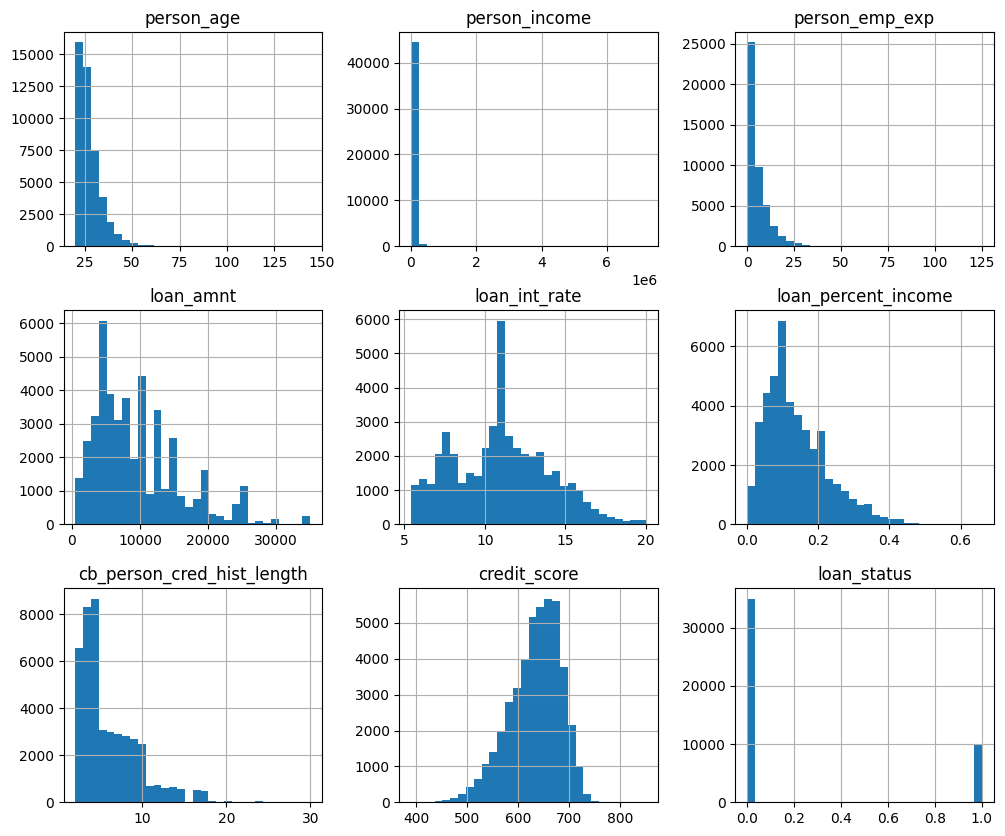

In [7]:
df[numerical_cols].hist(bins=30, figsize=(12,10))
plt.show()

Now lets check for the outliers that we saw earlier in columns **person_age** and **person_emp_exp** using boxplot

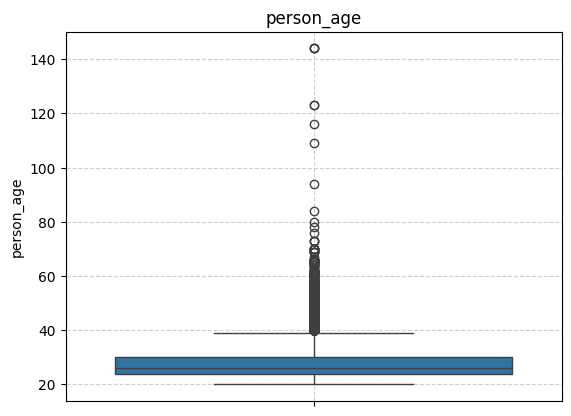

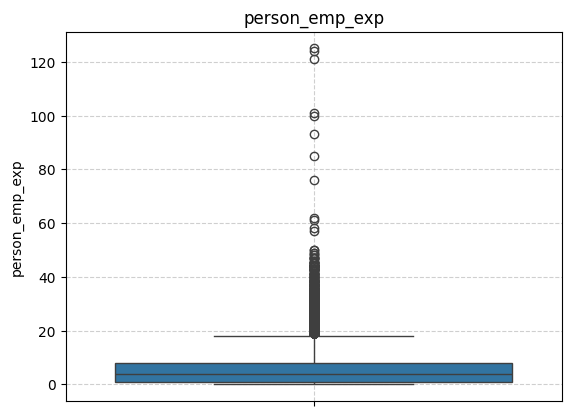

In [8]:
sns.boxplot(df['person_age'])
plt.title('person_age')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

sns.boxplot(df['person_emp_exp'])
plt.title('person_emp_exp')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

We'll set **80** as the age cutoff for outlier removal because the data above this value is too sparse to meaningfully influence the results.

In [9]:
df = df[df['person_age'] <= 80]

#### Correlation of ALL features

Let's look at the correlation of each feature with the target variable

**Numerical Columns**

In [10]:
df[numerical_cols].corr()['loan_status'].sort_values()

person_income                -0.169040
person_age                   -0.020348
person_emp_exp               -0.019326
cb_person_cred_hist_length   -0.014622
credit_score                 -0.007341
loan_amnt                     0.107721
loan_int_rate                 0.332040
loan_percent_income           0.384885
loan_status                   1.000000
Name: loan_status, dtype: float64

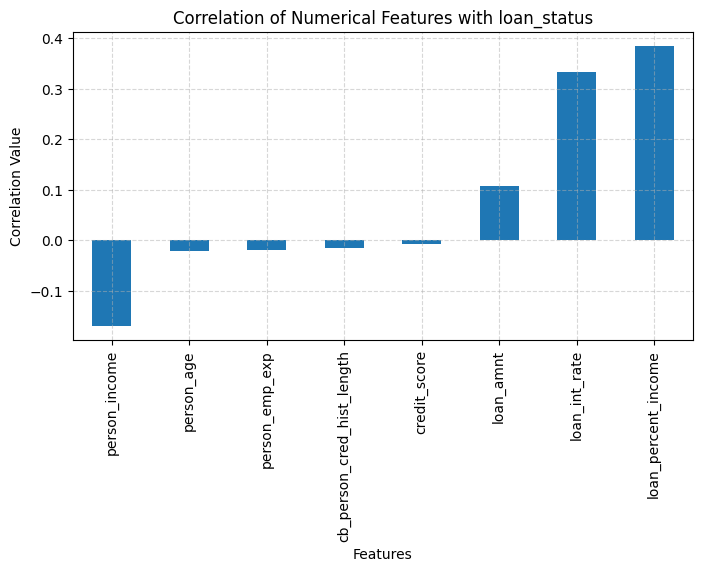

In [11]:
# Visualizing the correlation

corr_values = df[numerical_cols].corr()['loan_status'].drop('loan_status')

plt.figure(figsize=(8,4))
corr_values.sort_values().plot(kind='bar')
plt.title('Correlation of Numerical Features with loan_status')
plt.xlabel('Features')
plt.ylabel('Correlation Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Categorical Columns**

In [12]:
#Label Encode All Categorical Columns
df_encoded = df.copy()
le = LabelEncoder()

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [13]:
# Compute Correlation of Each Categorical Feature with loan_status
cat_corr_values = df_encoded[categorical_cols].corrwith(df_encoded['loan_status'])
cat_corr_values = cat_corr_values.sort_values()
print(cat_corr_values)

previous_loan_defaults_on_file   -0.543204
loan_intent                      -0.072099
person_education                 -0.001752
person_gender                    -0.000513
person_home_ownership             0.233848
dtype: float64


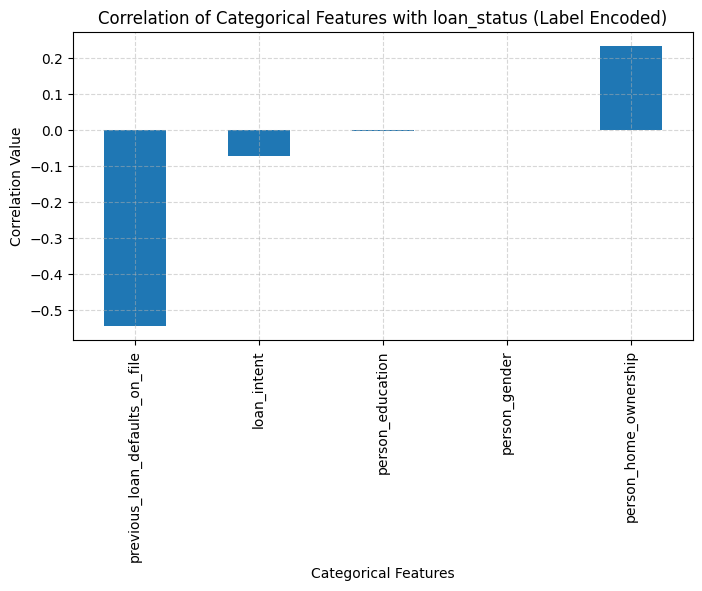

In [14]:
# Plot the Correlation Bar Chart

plt.figure(figsize=(8,4))
cat_corr_values.plot(kind='bar')
plt.title('Correlation of Categorical Features with loan_status (Label Encoded)')
plt.xlabel('Categorical Features')
plt.ylabel('Correlation Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Multicollinearity check

Let's take a look at numerical columns to check for multicollinearity.

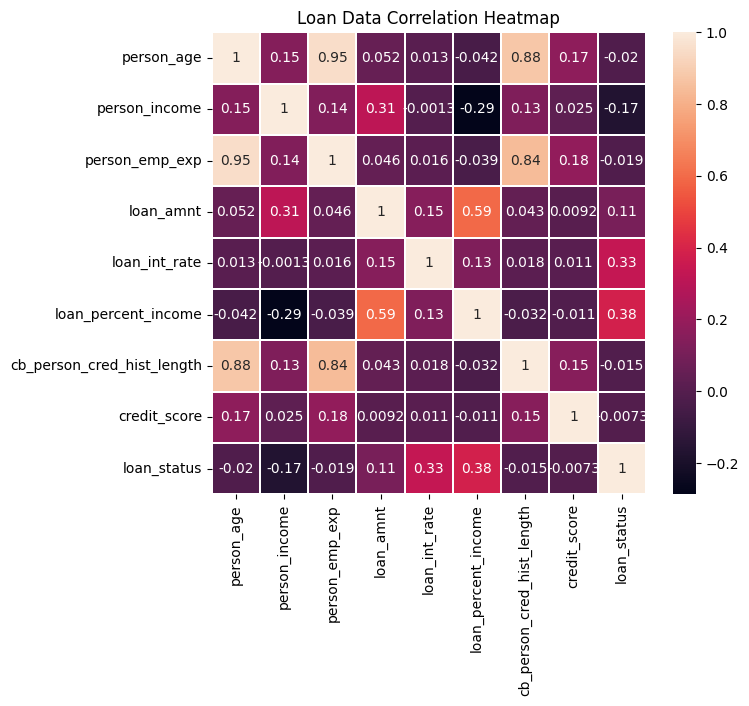

In [15]:
# Correlation Heatmap
plt.figure(figsize = (7,6))
plt.title("Loan Data Correlation Heatmap")
sns.heatmap(df[numerical_cols].corr(), annot = True, linewidths = .1);

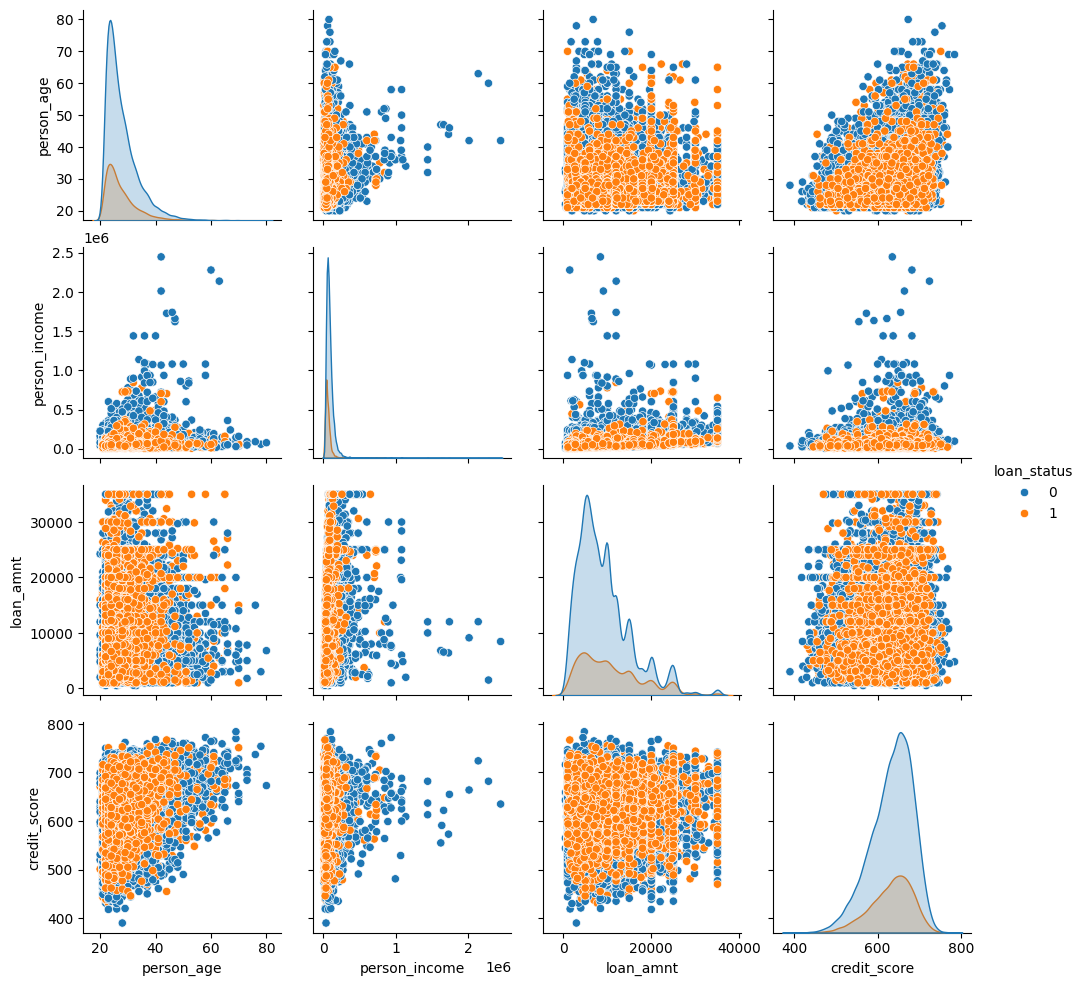

In [16]:
sns.pairplot(df[['person_age', 'person_income', 'loan_amnt', 'credit_score','loan_status']], 
             hue='loan_status')
plt.show()

From these graphs, we can clearly understand that **person_age**, **person_emp_exp** and **cb_person_cred_hist_length** are too strongly correlated

#### Target Variable

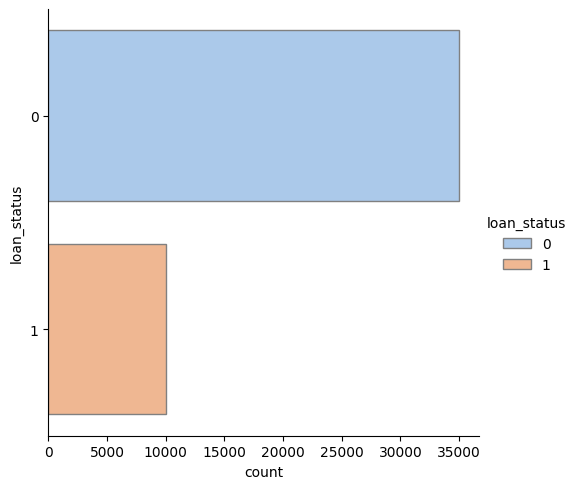

In [17]:
# Target variable distribution
sns.catplot(df, y = "loan_status", kind = "count", hue = "loan_status", palette = "pastel", edgecolor = ".5");

The distribution of target variable is not evenly balanced

### Data split into Training and Testing

In [18]:
# Splitting into train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_train, df_val = train_test_split(df_full_train, test_size = 0.2, random_state = 42)

In [19]:
# Check datasets sizes after splitting
len(df_train),len(df_val), len(df_test)

(28793, 7199, 8999)

In [20]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

### Feature Importance Analysis

To evaluate feature importance, we can use the **mutual information** score for categorical variables, and the **pearson correlation** for numerical ones.

**Mutual Information**

Mutual information (MI) in machine learning quantifies the statistical dependence between two random variables, measuring how much knowing one variable reduces the uncertainty about the other. It's used to assess the relationship between features and a target variable, which is valuable for tasks like feature selection, where features with high mutual information are deemed more relevent to the model's predictive power.

In [21]:
# Prepare X and Y
num_cols = [col for col in numerical_cols if col != 'loan_status']
X = df_encoded[num_cols + list(categorical_cols)]
y = df_encoded['loan_status']

In [22]:
# Compute Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=1)

In [23]:
# Put the results in a Dataframe
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_scores)

previous_loan_defaults_on_file    0.197195
person_income                     0.091012
loan_percent_income               0.083351
loan_int_rate                     0.069400
person_home_ownership             0.037820
loan_amnt                         0.016747
loan_intent                       0.011944
person_gender                     0.006760
person_education                  0.005748
person_age                        0.004389
credit_score                      0.002936
person_emp_exp                    0.000105
cb_person_cred_hist_length        0.000000
dtype: float64


The most important feature is **previous_loan_defaults_on_file** and least important is **cb_person_cred_hist_length**

**Pearson Correlation**

Pearson correlation measures the strength and direction of a linear relationship between two variables

In [24]:
# Absolute correlations between numerical columns and target
df_train[numerical_cols].corrwith(df_train.loan_status).abs().sort_values(ascending = False)

loan_status                   1.000000
loan_percent_income           0.382941
loan_int_rate                 0.331035
person_income                 0.168850
loan_amnt                     0.102381
person_age                    0.023304
person_emp_exp                0.021788
cb_person_cred_hist_length    0.016138
credit_score                  0.008957
dtype: float64

The most important numerical variaable is **loan_percent_income** and least one is **credit_score**

Now let's extract the target variable

In [25]:
# Get the loan status values
y_train = df_train.loan_status.values
y_test = df_test.loan_status.values
y_val = df_val.loan_status.values

# Drop `loan_status` from our data sets
del df_train["loan_status"]
del df_test["loan_status"]
del df_val["loan_status"]

#### One-hot Encoding

One-hot encoding is a data preprocessing technique that converts categorical data into a numerical format for machine learning algorithms

Before training Machine Learning models, as they only understand numbers, we will encode all categorical variables in our datasets with One-Hot-Encoding

In [26]:
# Convert training data in to list of dictionaries
train_dicts = df_train.to_dict(orient='records')

# Initialize OneHotEncoding
dv = DictVectorizer(sparse=False)

#Train it
X_train = dv.fit_transform(train_dicts)

In [27]:
# Convert the test data into list of dictionaries
val_dicts = df_val.to_dict(orient = 'records')

# Train it
X_val = dv.transform(val_dicts)

In [28]:
# Check the features
dv.get_feature_names_out()

array(['cb_person_cred_hist_length', 'credit_score', 'loan_amnt',
       'loan_int_rate', 'loan_intent=DEBTCONSOLIDATION',
       'loan_intent=EDUCATION', 'loan_intent=HOMEIMPROVEMENT',
       'loan_intent=MEDICAL', 'loan_intent=PERSONAL',
       'loan_intent=VENTURE', 'loan_percent_income', 'person_age',
       'person_education=Associate', 'person_education=Bachelor',
       'person_education=Doctorate', 'person_education=High School',
       'person_education=Master', 'person_emp_exp',
       'person_gender=female', 'person_gender=male',
       'person_home_ownership=MORTGAGE', 'person_home_ownership=OTHER',
       'person_home_ownership=OWN', 'person_home_ownership=RENT',
       'person_income', 'previous_loan_defaults_on_file=No',
       'previous_loan_defaults_on_file=Yes'], dtype=object)

## Model Training

The objective is to determine whether a customer should be approved for a loan. This is a classification problem where customer details serve as features and the loan status is the target variable.

To classify this data, we will fine tune **Logistic Regression**, **Decision Tree**, **Random Forest** & **XGBoost Classifier**

### Logistic Regression

Logistic regression is a supervised machine learning algorithm used for binary or categorical classification problems, predicting the probability of an outcome that has a finite number of results.

To optimize performance, the model will be trained and compared using different regularization settings.

In [29]:
# Parameter List
reg = [0.01, 0.1, 1, 2, 5, 10, 50, 100]

#Initialize score
reg_score = []

# Fine tuning the model
for c in reg:
    # Define the model
    model = LogisticRegression(solver = 'liblinear', C =c, max_iter = 1000, random_state = 42)
    model.fit(X_train, y_train)
    #Predicting
    y_pred = model.predict(X_val)
    #Accuracy checking
    accuracy = accuracy_score(y_val, y_pred)
    # Append reg score
    reg_score.append(accuracy)

In [30]:
param_scores = pd.Series(reg_score, index = reg, name = "parameters_scores")
param_scores

0.01      0.798861
0.10      0.798861
1.00      0.798861
2.00      0.798861
5.00      0.798861
10.00     0.798861
50.00     0.798861
100.00    0.798861
Name: parameters_scores, dtype: float64

Since the result seems to be constent,we will take **C = 0.01** and have an accuracy of **79.8%**

## Decision Tree Classifier

A decision tree is a supervised machine learning algorithm that uses a flowchart-like structure to make predictions for both classification and regression tasks

The parameters max_depth and min_samples_leaf have the strongest influence on the model’s predictions. Therefore, we will fine-tune the model using multiple values for these parameters.

In [31]:
# List of potential maximum depths
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, None]

# Decision Tree model fine-tuning with maximum depth
for depth in depths: 
    # Initialize the model with a max_depth
    model = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    # Model Training
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_val)
    # accuracy score
    acc = accuracy_score(y_val, y_pred)
    
    print('Maximum depth: %4s -> Accuracy score: %.3f' % (depth, acc))

Maximum depth:    1 -> Accuracy score: 0.779
Maximum depth:    2 -> Accuracy score: 0.853
Maximum depth:    3 -> Accuracy score: 0.889
Maximum depth:    4 -> Accuracy score: 0.905
Maximum depth:    5 -> Accuracy score: 0.908
Maximum depth:    6 -> Accuracy score: 0.907
Maximum depth:   10 -> Accuracy score: 0.916
Maximum depth:   15 -> Accuracy score: 0.910
Maximum depth:   20 -> Accuracy score: 0.899
Maximum depth:   25 -> Accuracy score: 0.897
Maximum depth: None -> Accuracy score: 0.897


From this we can see that depth **10** & **15** have great scores.

Now we will fine tune it with min_samples_leaf

In [32]:
# Initialize scores
scores = []

# Decision Tree fine-tuning with maximum-depth
for depth in [10, 15, 20]:
    # Decision Tree model fine-tuning with minimum samples per leaf
    for s in [1, 3, 5, 10, 15, 20, 100, 200, 500]:
        # Initialize the model with a max_depth and min_samples_leaf
        model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = s, random_state = 42)
        # Model training
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)
        # accuracy score
        acc = accuracy_score(y_val, y_pred)

        # Store parameters and score
        scores.append((depth, s, acc))

In [33]:
# Columns names
columns = ['max_depth', 'min_samples_leaf', 'acc']
# Create dataframe
df_scores = pd.DataFrame(scores, columns = columns)

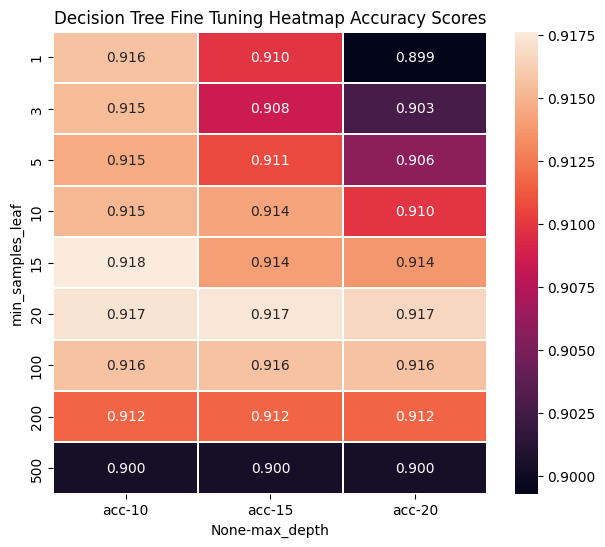

In [36]:
# Pivot table
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['max_depth'], values = ['acc'])

# Scores Heatmap
plt.figure(figsize=(7, 6))
plt.title("Decision Tree Fine Tuning Heatmap Accuracy Scores")
sns.heatmap(df_scores_pivot, annot = True, fmt = ".3f", linewidths = .1);

From this we can colclude that **min_samples_leaf = 15** and **max_depth = 10**

This decision tree has an accuracy of **91.8%**

### Random Forest Classifier

Random Forest is an ensemble machine learning algorithm that constructs multiple decision trees during training and combines their individual predictions to produce a more accurate and stable result

For fine tuning this model, we will be focusing on hyperparameters like n_estimators, max_depth and min_samples_leaf as these are the most imporatant hyperparameter

In [37]:
# Initialize scores
scores = []

# Possible number of estimators
n_params = np.arange(10, 201, 10)

# Random forest fine-tuning with maximum depth
for d in [5, 10, 15, 20, 25]:
    # Random forest fine-tuning with number of trees
    for n in n_params:
        # Initialize random forest classifier
        model = RandomForestClassifier(n_estimators = n, max_depth = d, random_state = 42, n_jobs = -1)
        # Model training
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)
        # accuracy score
        acc = accuracy_score(y_val, y_pred)

        # Store hyperparameters and corresponding score
        scores.append((d, n, acc))

In [39]:
# Columns names
columns = ['max_depth', 'n_estimators', 'acc']
# Dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
# Round mean accuracy for each depth
df_scores.groupby("max_depth")["acc"].mean().round(3)

max_depth
5     0.912
10    0.920
15    0.922
20    0.922
25    0.921
Name: acc, dtype: float64

The optimal value we will be using is **15**

Now will fine tune number of trees and min leaf samples

In [40]:
# Initialize scores
scores = []

# Values for min_samples_leaf
min_sampl = [1, 3, 5, 10, 50]

# Fine-tunining with minimum samples per leaf
for s in min_sampl:
    # Fine-tuning with number of estimators
    for n in n_params:
        # Initialize model
        model = RandomForestClassifier(n_estimators = n, max_depth = 15, min_samples_leaf = s, random_state = 42, n_jobs = -1)
        # Model training
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)
        # accuracy score
        acc = accuracy_score(y_val, y_pred)

        # Store hyperparameters and score
        scores.append((s, n, acc))

In [41]:
# Column names
columns = ['min_samples_leaf', 'n_estimators', 'acc']
# Dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
# Round mean accuracy for each depth
df_scores.sort_values(by = ["acc", "n_estimators"], ascending = [False, True]).head(5)

,min_samples_leaf,n_estimators,acc
18,1,190,0.922906
17,1,180,0.922767
16,1,170,0.922628
28,3,90,0.922489
32,3,130,0.922489


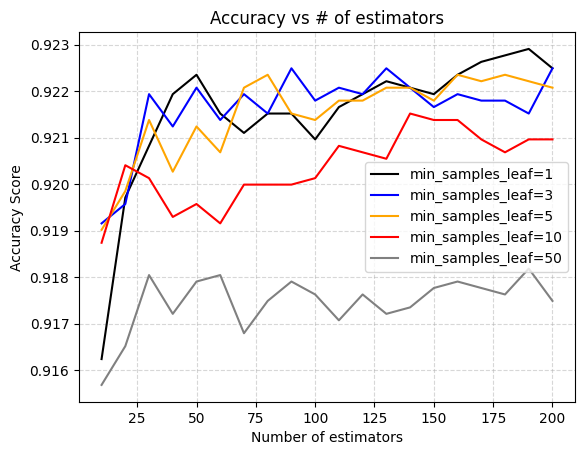

In [42]:
# Colors sets
colors = ['black', 'blue', 'orange', 'red', 'grey']

for i in range(len(min_sampl)):
    s = min_sampl[i]        # min_samples_leaf value
    col = colors[i]         # matching color

    df_subset = df_scores[df_scores.min_samples_leaf == s]

    plt.plot(df_subset.n_estimators, df_subset.acc,
             color=col,
             label=f"min_samples_leaf={s}")

plt.xlabel("Number of estimators")
plt.ylabel("Accuracy Score")
plt.title("Accuracy vs # of estimators")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

These findings indicate that the combination of **max_depth = 15**, **min_samples_leaf = 3**, and **n_estimators = 90** delivers the most effective hyperparameter tuning, achieving a **92.2%** accuracy

### XGBoost Classifier

XGBoost Classifier is a machine learning algorithm for solving classification problems, a specific application of the broader XGBoost (Extreme Gradient Boosting) framework. It is an optimized and highly efficient implementation of the gradient boosting algorithm, primarily using decision trees as its base learners.

For fine-tuning, we will focus on optimizing the eta hyperparameter, using max_depth (10 and 15 from decision tree) as determined from the previous analysis.

We will also update train and test sets to get the DMatrix format that works best with xgboost, and create a watchlist to traceback scores during model training.

In [43]:
features = list(dv.get_feature_names_out())
# Wrap the training data into an optimized structure
dm_train = xgb.DMatrix(X_train, label = y_train, feature_names = features)
# Wrap the test data into an optimized structure
dm_val = xgb.DMatrix(X_val, label = y_val, feature_names = features)

# Dataset on which we want to iterate our model
watchlist = [(dm_train, 'train'), (dm_val, 'val')]

With max_depth = 10

In [45]:
# List of learning rates parameters
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# XgBoost fine-tuning with learning rates
for eta in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta, 
        'max_depth': 10,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dm_train, num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dm_val) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 15, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], accuracy_score(y_val, y_pred)))

eta = 0.1, max_depth = 15, min_child_weight = 1, accuracy = 0.929.
eta = 0.3, max_depth = 15, min_child_weight = 1, accuracy = 0.930.
eta = 0.5, max_depth = 15, min_child_weight = 1, accuracy = 0.926.
eta = 0.7, max_depth = 15, min_child_weight = 1, accuracy = 0.924.
eta = 0.9, max_depth = 15, min_child_weight = 1, accuracy = 0.922.


With max_depth = 15

In [46]:
# List of learning rates parameters
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# XgBoost fine-tuning with learning rates
for eta in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta, 
        'max_depth': 15,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dm_train, num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dm_val) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 15, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], accuracy_score(y_val, y_pred)))

eta = 0.1, max_depth = 15, min_child_weight = 1, accuracy = 0.927.
eta = 0.3, max_depth = 15, min_child_weight = 1, accuracy = 0.927.
eta = 0.5, max_depth = 15, min_child_weight = 1, accuracy = 0.926.
eta = 0.7, max_depth = 15, min_child_weight = 1, accuracy = 0.923.
eta = 0.9, max_depth = 15, min_child_weight = 1, accuracy = 0.922.


From this we can conclude that **eta = 0.3** is the best hyperparameter tuning along with **max_depth = 10** which result in an accuracy of **93%**

## Model Deployment

Now we will train our models using K-fold cross validation to evaluate its performance. Then we will train the model with full training dataset and predict the model with test dataset 

In [48]:
# Function for training a XGBClassifier Model

def train_xgbc(df_train, y_train, eta=0.3, max_depth = 10):
    # Convert training data in to list of dictionaries
    train_dicts = df_train.to_dict(orient='records')
    # Initialize OneHotEncoding
    dv = DictVectorizer(sparse=False)
    #Train it
    X_train = dv.fit_transform(train_dicts)

    features = list(dv.get_feature_names_out())
    # Wrap the training data into an optimized structure
    dm_train = xgb.DMatrix(X_train, label = y_train, feature_names = features)
     # Model's parameters
    xgb_params = {
        'eta': eta, 
        'max_depth': 15,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    
    model = xgb.train(xgb_params, dm_train, num_boost_round = 200)

    return dv, model
    

In [86]:
# Function for predicting XGBC

def predict_xgbc(df, dv, model):

    # Convert df → dict
    dicts = df[list(categorical_cols) + list(num_cols)].to_dict(orient='records')

    # One-hot encode using dv
    X = dv.transform(dicts)

    # Convert numpy array of feature names → Python list
    feature_names = dv.get_feature_names_out().tolist()

    # Create DMatrix
    dtest = xgb.DMatrix(X, feature_names=feature_names)

    # Predict
    y_pred = model.predict(dtest)

    return (y_pred >= 0.5)

In [94]:
# Function to train Logistic regression 
def train_log_reg(df_train, y_train):
    # Convert df → dict format
    dicts = df_train[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    # Train Logistic Regression
    model = LogisticRegression(solver = 'liblinear', C =0.01, max_iter = 1000, random_state = 42)
    model.fit(X_train, y_train)

    return dv, model

# Function to predict
def predict_log_reg(df_val, dv, model):
    dicts = df_val[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    X_val = dv.transform(dicts)
    y_pred = model.predict(X_val)
    return y_pred


In [95]:
# Function to train Decision tree

def train_dt(df_train, y_train):
    dicts = df_train[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = DecisionTreeClassifier(
        max_depth=10, 
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train, y_train)

    return dv, model

# Function to predict
def predict_dt(df_val, dv, model):
    dicts = df_val[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    X_val = dv.transform(dicts)
    y_pred = model.predict(X_val)
    return y_pred


In [108]:
# Function to train Random forest
def train_rf(df_train, y_train):
    dicts = df_train[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = RandomForestClassifier(
        n_estimators=90,
        max_depth=15,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    return dv, model

# Function to predict
def predict_rf(df_val, dv, model):
    dicts = df_val[list(categorical_cols) + list(num_cols)].to_dict(orient='records')
    X_val = dv.transform(dicts)
    y_pred = model.predict(X_val)
    return y_pred


## Cross-Validation

Cross-validation is a machine learning technique used to evaluate a model's performance and prevent issues like overfitting, by systematically splitting the dataset into multiple subsets (or "folds")

Let's validate our model before final prediction using **k-fold cross-validation** method

In [97]:
# Generic function to use K-fold cross validation
def run_kfold(model_name, train_fn, predict_fn, df_full_train, n_splits=5):
    
    print(f"Running KFold for {model_name}...")
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    fold = 1

    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.loan_status.values
        y_val = df_val.loan_status.values
        
        # Train
        dv, model = train_fn(df_train, y_train)
        
        # Predict
        y_pred = predict_fn(df_val, dv, model)
        
        # Score
        acc = accuracy_score(y_val, y_pred)
        scores.append(acc)

        print(f"Fold {fold} accuracy: {acc:.4f}")
        fold += 1

    print("====================================")
    print(f"{model_name} Results:")
    print("Mean Accuracy:", round(np.mean(scores),4))
    print("Std Dev:", round(np.std(scores),4))
    print("====================================\n")


In [98]:
run_kfold("Logistic Regression", train_log_reg, predict_log_reg, df_full_train)
run_kfold("Decision Tree", train_dt, predict_dt, df_full_train)
run_kfold("Random Forest", train_rf, predict_rf, df_full_train)
run_kfold("XGBoost", train_xgbc, predict_xgbc, df_full_train)

Running KFold for Logistic Regression...
Fold 1 accuracy: 0.7979
Fold 2 accuracy: 0.8383
Fold 3 accuracy: 0.7924
Fold 4 accuracy: 0.7911
Fold 5 accuracy: 0.7934
Logistic Regression Results:
Mean Accuracy: 0.8026
Std Dev: 0.018

Running KFold for Decision Tree...
Fold 1 accuracy: 0.9269
Fold 2 accuracy: 0.9232
Fold 3 accuracy: 0.9211
Fold 4 accuracy: 0.9144
Fold 5 accuracy: 0.9204
Decision Tree Results:
Mean Accuracy: 0.9212
Std Dev: 0.0041

Running KFold for Random Forest...
Fold 1 accuracy: 0.9303
Fold 2 accuracy: 0.9296
Fold 3 accuracy: 0.9286
Fold 4 accuracy: 0.9225
Fold 5 accuracy: 0.9261
Random Forest Results:
Mean Accuracy: 0.9274
Std Dev: 0.0028

Running KFold for XGBoost...
Fold 1 accuracy: 0.7821
Fold 2 accuracy: 0.7807
Fold 3 accuracy: 0.7765
Fold 4 accuracy: 0.7729
Fold 5 accuracy: 0.7783
XGBoost Results:
Mean Accuracy: 0.7781
Std Dev: 0.0032



From this it is clearly visible that XGBClassifer was overfitting.

We will be choosing our final model as **Random Forest** with a mean accuracy of **92.7%** 

## Training the final model

Let's now train our model on the full training data set, and evaluate it on the test set.

In [109]:
# assigning the target variable to y
y_full = df_full_train.loan_status.values
# Training random forest with train + validation
dv_final, model_final = train_rf(df_full_train, y_full)

In [110]:
# Predicting the final model with test dataset
y_pred = predict_rf(df_test, dv_final, model_final)

In [111]:
# Accuracy score
test_acc = accuracy_score(y_test, y_test_pred)
print("Final Test Accuracy:", test_acc)

Final Test Accuracy: 0.92565840648961


## Conclusion

After performing extensive exploratory data analysis, feature engineering, model training, and evaluation, multiple machine learning algorithms were tested, including Logistic Regression, Decision Tree, Random Forest, and XGBoost. Each model was validated using K-Fold Cross-Validation to ensure stable and unbiased performance measurement.

Among all the models evaluated, Random Forest consistently achieved the highest accuracy and demonstrated the best generalization performance across training and validation folds. Its ability to handle nonlinear relationships and mixed feature types made it the most reliable choice for predicting customer loan eligibility.

Based on these results, **Random Forest was selected as the final model** for deployment. The model was retrained on the full training dataset (df_full_train) to capture all available patterns in the data. To make the model reusable and ready for production, it wii be saved using the pickle library, allowing for easy loading and prediction on new customer data.

## Save the model

Lets save our model and encoder used to a file using pickle library

In [105]:
# model file name
output_file = 'model_random_forest.bin'
output_file

'model_random_forest.bin'

In [116]:
# Open file and write into it
with open(output_file, 'wb') as f_out: 
    # Save model
    print("Storing the model into a file")
    pickle.dump((dv, model_final), f_out)
    
print(f"The model is saved to {output_file}.")

Storing the model into a file
The model is saved to model_random_forest.bin.
